# Image Completion:
In what follows, we will remove a part of an image and try to reconstruct it. The images are resized to 256x256 and grayscaled to have 1 channel. The outpout size will also be the 256x256x1 but only the removed part will be considered as an output and for calculating the loss. The model used is a simple Autoencoder and the loss used is MSE loss.

Note: Please make sure to download all packages before running the notebook. Uncomment the following line to do so:

In [ ]:
# !pip install -r requirements.txt

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Your code goes here ####
## step 1: download and unzip
from src.dataset import util
import os
import glob
import torch
from torchvision import transforms
import numpy as np
from skimage import io

url = 'https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB-Training_fixed.zip'
dataset_dir = os.path.join(util.get_dataset(url), 'GTSRB')
train_dir = os.path.join(dataset_dir, 'Training')


creating directories...
data dir exists
/home/kareem/PycharmProjects/IBM_Lab/Ex1/data/GTSRB-Training_fixed  exists
Dir is not empty
zip file doesnt exist


number of classes 43
training size 26640


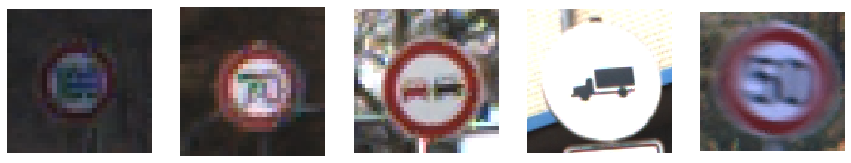

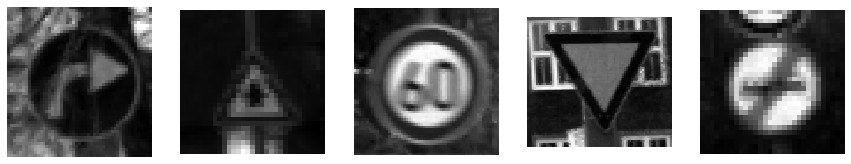

In [2]:
# step 2: visualize images randomly
imgs_path = glob.glob(os.path.join(dataset_dir, f'**/*.ppm'), recursive=True)
print('number of classes', len(os.listdir(train_dir))-1)
print('training size', len(imgs_path))
util.visualize_samples(imgs_path, n_cols=5, n_rows=1)
# step 3: visualize images in grayscale
util.visualize_samples(imgs_path, gray=True, n_cols=5, n_rows=1)

Note: input size is 256x256x1 and output size 40x40x1

26640
(256, 256) (256, 256) (40, 40)


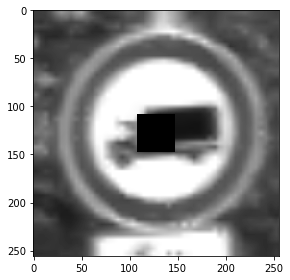

In [3]:
# step 4: dataset
from src.dataset.customDataset import custumDataset

dataset = custumDataset(dataset_dir)
img, in_img, target_img = dataset[0]
io.imshow(in_img)

dataset = custumDataset(dataset_dir, transform=transforms.ToTensor())
print(len(dataset))
print(img.shape, in_img.shape, target_img.shape) #full image

In [4]:
# step 5: split
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
print(len(train_dataset))
print(len(val_dataset))

18648
7992


In [5]:
# step 6 dataloader
from torch.utils.data import DataLoader
import multiprocessing as mp

batch_size = 32
# note that dataloaders are added to src.Model.Solver.Trainer.
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=mp.cpu_count())
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=mp.cpu_count())
print('number of batches')
print(len(train_loader))
print(len(val_loader))

number of batches
583
250


## The Model
In what follows I will be using an Autoencoder model. The model will take as an input the 256x256x1 with the 40x40 pixels in the middle set to 0. The output will also be 256x256x1 but the loss will only be computed on the blacked out pixels. It uses four convlution and pooling layer for the encoder and 4 upsampling and convlution layers for the decoder. Also Xavier/2 weights initialization was used which helps much in having faster convergence. More possible models will be discussed at the end of the notebook.
## Optimization and Visualization
Adam optimizer with MSE loss are used. The Trainer class will manage the training of the model and it supports an early stopping criteria, a schedular, TensorBoard logging(loss, accuracy and images), and saves a checkpoint of the model at the lowest loss value. Retraing the model is also possible (either from the checkpoint or by saving the moddle with the 'inference' flag as False).

The following is a small test for the model.

583
input shape torch.Size([32, 1, 256, 256]) 
output shape torch.Size([32, 1, 256, 256])


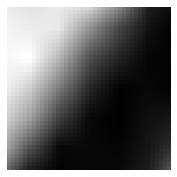

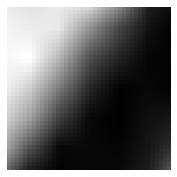

In [6]:
### Your code goes here ####
from src.Model.Networks import AutoEncoder
from matplotlib import pyplot as plt
from src.dataset.util import visualize_torch

model_hparams = {
    "filter_channels": 8,
    "filter_size": 3,
    "dropout": 0.02,
    }

AE_model = AutoEncoder(input_channels=1, hparams=model_hparams)
for batch in train_loader:
    print(len(train_loader))
    image, in_img, target_img = batch
    output = AE_model(in_img.float())
    target_center=[128,128]
    target_size=40
    top = int(target_center[0] - (target_size / 2))
    left = int(target_center[1] - (target_size / 2))
    cropped = image[:,:,top:top+target_size,left:left+target_size]
    visualize_torch(cropped, gray=True, n_cols=1, n_rows=1)
    visualize_torch(target_img, gray=True, n_cols=1, n_rows=1)
    print('input shape', in_img.shape, '\noutput shape', output.shape)
    assert output.shape == in_img.shape
    break

## Stopping Criteria
The patience flag passed to the Trainer along with the val_epoch controlls the stopping criteria. The number of bad epochs is calculated as following: if the validation epoch loss is larger than the minimumn validation loss a penalty (+1) is counted, and if it is greater an award is counted (-1) as long as the value remains above 0. If the number of bad_epochs = patience then the training will stop. The reason why the validation loss is tracked is because we want our model to generalize on unseen data.

## Checkpoint
When checkpoint_dir is assigned to the Trainer, the model with the minimum validation loss will be saved in the given directory.

## StepLR Schedular
The schedular will multiply the learning rate by 'gamma' every 'step_size' steps


## Hyperparameter Tuning
A small manual hypermarameter tunning was done. Nevertheless, this can be imporved by using some framework such as Optuna and many other.


Note: Run "tensorboard --logdir=runs" to open tensorboard

Note: A model checkpoint is attached. Therefore running the training again is not required. The model checkpoint can be loaded and then used for inference or for further training. Also the model's Tensorboard file is attached.

In [7]:
### Your code goes here ####
from torch import nn
from src.Model.Solver import Trainer
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

model_hparams = {
    "filter_channels": 32,
    "filter_size": 3,
    "dropout": 0.02,
}
optimizer_hparams = {
    "lr":0.001,
    "weight_decay":1e-5,

}
schedular_params = {
    "step_size": 30,
    "gamma": 0.5,
}

AE_model = AutoEncoder(input_channels=1, hparams=model_hparams)
optimizer = Adam(AE_model.parameters(), **optimizer_hparams)
scheduler = StepLR(optimizer, **schedular_params)

trainer_hparams = {
    "batch_size":32,
    "optimizer":optimizer,
    "criterion": nn.MSELoss(reduction='none'),
    "cuda": torch.cuda.is_available(),
    "scheduler": scheduler,
}

models_dir = os.path.join('data', 'models')
checkpoint_dir = os.path.join(models_dir, 'AEModel')
if not os.path.exists(models_dir):
        os.mkdir(models_dir)
        
trainer = Trainer(AE_model, train_dataset, val_dataset, **trainer_hparams, 
                  patience=5, checkpoint_dir=checkpoint_dir)

train_model = True

if train_model:
    trainer.train(n_epochs=100, val_epoch=1, logs_dir='AEModel')
    print('run \'tensorboard --logdir=runs\' to open tensorboard')
        

Cuda is available


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0375. Acc: 0.4262


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0100. Acc: 0.5684
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0099. Acc: 0.5355


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0107. Acc: 0.5230


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0080. Acc: 0.5819


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0070. Acc: 0.6264
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0066. Acc: 0.6317


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0059. Acc: 0.6608
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0059. Acc: 0.6633


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0049. Acc: 0.7039
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0052. Acc: 0.6928


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0063. Acc: 0.6688


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0049. Acc: 0.7085


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0042. Acc: 0.7351
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0044. Acc: 0.7316


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0038. Acc: 0.7512
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0041. Acc: 0.7446


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0032. Acc: 0.8084
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0039. Acc: 0.7591


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0034. Acc: 0.7967


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0038. Acc: 0.7612


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0035. Acc: 0.7850


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0038. Acc: 0.7688


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0028. Acc: 0.8288
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0037. Acc: 0.7736


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0027. Acc: 0.8383
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0034. Acc: 0.7924


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0026. Acc: 0.8442
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0031. Acc: 0.8072


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0026. Acc: 0.8522
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0030. Acc: 0.8173


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0027. Acc: 0.8427


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0029. Acc: 0.8282


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0023. Acc: 0.8668
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0028. Acc: 0.8325


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0022. Acc: 0.8768
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0027. Acc: 0.8393


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0023. Acc: 0.8770


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0026. Acc: 0.8487


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0028. Acc: 0.8256


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0026. Acc: 0.8509


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0021. Acc: 0.8844
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0025. Acc: 0.8571


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0021. Acc: 0.8800


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0023. Acc: 0.8687


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0022. Acc: 0.8743


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0023. Acc: 0.8710


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0020. Acc: 0.8999
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0024. Acc: 0.8698


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0019. Acc: 0.8946
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0023. Acc: 0.8741


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0019. Acc: 0.9069
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0022. Acc: 0.8792


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0019. Acc: 0.8989


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0023. Acc: 0.8708


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0023. Acc: 0.8568


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0022. Acc: 0.8802


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0020. Acc: 0.8852


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0021. Acc: 0.8877


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0020. Acc: 0.8833


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0016. Acc: 0.9304


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0018. Acc: 0.9104
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0015. Acc: 0.9385


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0017. Acc: 0.9077
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0015. Acc: 0.9419


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0017. Acc: 0.9139
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0015. Acc: 0.9419


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0015. Acc: 0.9244
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0015. Acc: 0.9461


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0016. Acc: 0.9173


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0014. Acc: 0.9507


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0016. Acc: 0.9186


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0014. Acc: 0.9539


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0015. Acc: 0.9255
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0014. Acc: 0.9529


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0014. Acc: 0.9347
Checkpoint saved.  data/models/AEModel/checkpoint.model


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0014. Acc: 0.9551


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0015. Acc: 0.9295


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0013. Acc: 0.9562


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0014. Acc: 0.9326


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0013. Acc: 0.9580


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0016. Acc: 0.9170


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0013. Acc: 0.9608


  0%|          | 0/583 [00:00<?, ?it/s]

Validate Loss: 0.0015. Acc: 0.9295


  0%|          | 0/250 [00:00<?, ?it/s]

Training Loss: 0.0013. Acc: 0.9640


Validate - loss 0.0015: 100%|██████████| 250/250 [00:20<00:00, 12.16it/s]


Validate Loss: 0.0015. Acc: 0.9276
Patience reached.
Total loss 0.0016375216023555566. Total acc 0.35603934391080616
Finished Training
run 'tensorboard --logdir=runs' to open tensorboard


Saving and loading the model manually

In [18]:
save_model = True
inference = True #if False saves model for retraining and not just inference
model_path = os.path.join(models_dir, 'AEModel_Adam_StepLR_50_2.model')
if save_model:
    trainer.save(model_path, inference=inference)

Model saved.  data/models/AEModel_Adam_StepLR_50_2.model


In [26]:
load_model = True
inference = False
load_path = os.path.join(checkpoint_dir, 'checkpoint_best.model')
if load_model:
    trainer.load(load_path, inference=inference)

Checkpoint loaded.  data/models/AEModel/checkpoint_best.model


Note: retraining the models/AEModel/checkpoint_best.model mentioned before might most likely not produce significantly better results but rather the model is expected to start overfitting and that is because of the stopping criteria mentioned before.

In [10]:
retrain_model = False
if retrain_model:
    trainer.train(n_epochs=3, val_epoch=3, logs_dir='AEModel')

## Evaluation: 
### Accuracy
The accuracy is calculated based on 0.005 precision. That is the average loss of each sample is compared with 0 with a tolerance of 0.005 and if it is within the range a point will be rewarded. Then this value is summed for all samples and averages accross batches and then accross the whole training dataset.
### Loss
Since it is a regretion problem the MSELoss is also used as a metric to evaluate the model

In [27]:
### Your code goes here ####
# Part 1: Evaluation
total_loss, total_accuracy = trainer.evaluate()
print(f'Total loss {total_loss}. Total accuracy {total_accuracy}')


Validate - loss 0.0014: 100%|██████████| 250/250 [00:20<00:00, 12.14it/s]


Validate Loss: 0.0014. Acc: 0.9347
Total loss 0.0014137535423506052. Total accuracy 0.9346666666666666


Visualizing training data


/home/kareem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/home/kareem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


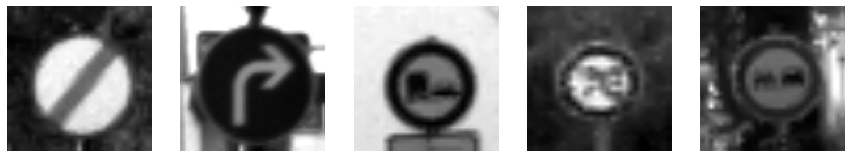

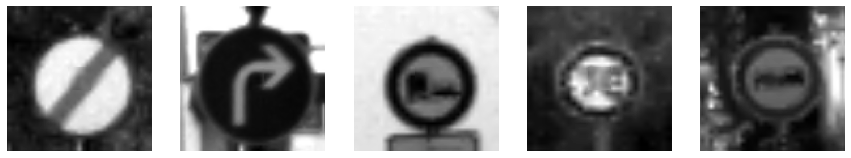

In [31]:
# Part 2: visualization from training data.
## note: one raw groundtruth and the following one prediction

print('Visualizing training data')
output_train_images, target_imgs = trainer.inference(loader=trainer.train_loader)
visualize_torch(target_imgs, gray=True).show()
visualize_torch(output_train_images, gray=True).show()

Visualizing validation data


/home/kareem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.
/home/kareem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  """


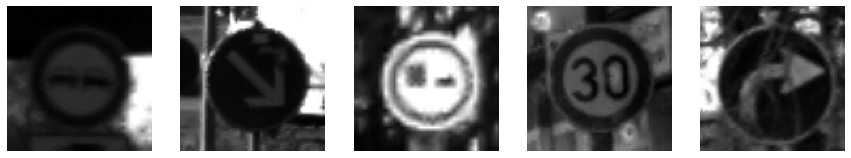

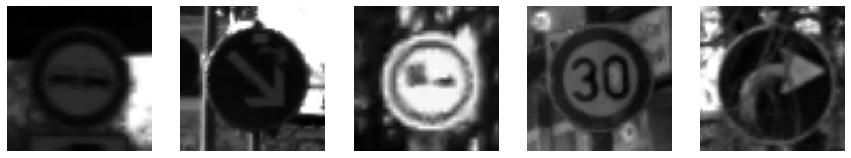

In [29]:
# Part 3: visualization from validation data.
print('Visualizing validation data')
output_test_images, target_imgs = trainer.inference(loader=trainer.valid_loader)
visualize_torch(target_imgs, gray=True).show()
visualize_torch(output_test_images, gray=True).show()


creating directories...
data dir exists
/home/kareem/PycharmProjects/IBM_Lab/Ex1/data/TSRD-Test  exists
Dir is not empty
zip file doesnt exist


/home/kareem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  
/home/kareem/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


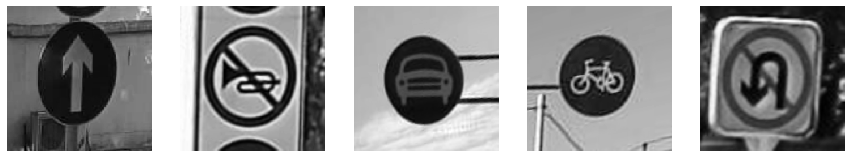

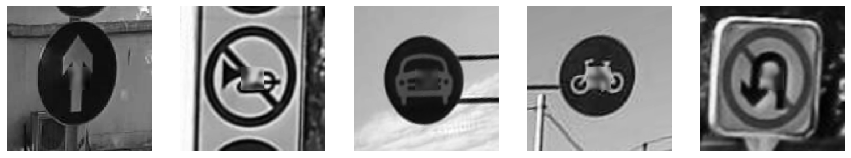

In [32]:
# Part 4: visualize images differnet dataset (TSRD)
url = 'http://www.nlpr.ia.ac.cn/pal/trafficdata/TSRD-Test.zip'
dataset_dir = os.path.join(util.get_dataset(url))

tsrd_dataset = custumDataset(dataset_dir, ext='*.png', transform=transforms.ToTensor())
tsrd_loader = DataLoader(tsrd_dataset, batch_size=32, num_workers=mp.cpu_count())
output_online_images, target_imgs = trainer.inference(loader=tsrd_loader)
visualize_torch(target_imgs, gray=True).show()
visualize_torch(output_online_images, gray=True).show()

## Comments
### Choice of the model:
When talking about generative models, one can immediately think about Autoencoders, Variational Autoencoders (VAEs), or GANs. The difference between Autoencoders and VAEs or GANs is that the later ones predicts parameters for the distribution of the output and then an output is sampled from the distribution. Whereas, Autoencoders directy prident the output which suits our task better since we dont need to learn a distribution but we only car about one ouput. 
### Improving the model:
Even that the current model gives verry good results, some improvments can be made such as using a UNet model which also an autoencoder but links every level of decoder and encoder together through directly. This always longer training and prevents from overfitting.

Another proposal would be to use a pretrained decoder, fine tune it, and then train the encoder. This will allow the encoder to predict better image features rather than learning from images which are distorted in the middle.

### Generaliztion
As is shown in the last cell, the results were not as good as we expects. Collect more images or applying data augmentation could be a way overcome this problem and achieve better generalization.

### Snapshots
The runned notebook as a pdf, and snapshots from Tensorboard are attached to the snapshots folder.